# LSTMs for Text Generation

In [1]:
import os
from six.moves.urllib.request import urlretrieve
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass



## Downloading Stories
Stories are automatically downloaded from https://www.cs.cmu.edu/~spok/grimmtmp/, if not detected in the disk. The total size of stories is around ~500KB. The dataset consists of 209 stories.

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
dir_name = 'data'

def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right size."""
      
    # Create directories if doesn't exist
    os.makedirs(download_dir, exist_ok=True)
    
    # If file doesn't exist download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)
        
    return filepath

# Number of files and their names to download
num_files = 209
filenames = [format(i, '03d')+'.txt' for i in range(1,num_files+1)]

# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)
    
# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print('{} files found.'.format(len(filenames))) 

209 files found.


## Split train, validation and test data

In [3]:
from sklearn.model_selection import train_test_split

# Fix the random seed so we get the same outptu everytime
random_state = 54321

filenames = [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5, random_state=random_state) 

# Print out the sizes and some sample filenames
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print("Got {} files in the {} dataset (e.g. {})".format(len(subset), subset_id, subset[:3]))

Got 167 files in the train dataset (e.g. ['data\\117.txt', 'data\\133.txt', 'data\\069.txt'])
Got 21 files in the valid dataset (e.g. ['data\\023.txt', 'data\\078.txt', 'data\\176.txt'])
Got 21 files in the test dataset (e.g. ['data\\129.txt', 'data\\207.txt', 'data\\170.txt'])


## Find the vocabulary size

In [4]:
bigram_set = set()

# Go through each file in the training set
for fname in train_filenames:
    document = [] # This will hold all the text
    with open(fname, 'r') as f:
        for row in f:
            # Convert text to lower case to reduce input dimensionality
            document.append(row.lower())
            
        # From the list of text we have, generate one long string (containing all training stories)
        document = " ".join(document)
        
        # Update the set with all bigrams found
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])

# Assign to a variable and print 
n_vocab = len(bigram_set)
print("Found {} unique bigrams".format(n_vocab))

Found 705 unique bigrams


## Reading data and generate batches for the model (`tf.data` API)

Here we are going to define a somewhat complex `tf.data` pipeline that would do all the required transformations for us.

In [16]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ Generate batched data from a list of files speficied """
    
    # Read the data found in the documents
    documents = []
    for f in filenames:
        doc = tf.io.read_file(f)
        doc = tf.strings.ngrams(    # Generate ngrams from the string
            tf.strings.bytes_split(    # Create a list of chars from a string
                tf.strings.regex_replace(    # Replace new lines with space
                    tf.strings.lower(    # Convert string to lower case
                        doc
                    ), "\n", " "
                )
            ),
            ngram_width, separator=''
        )
        documents.append(doc.numpy().tolist())
    
    # documents is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the ngrams (e.g. abcd -> ab, bc, cd) with overlap, however for our data
    # we do not need the overlap, so we need to skip the overlapping ngrams
    # the following line does that
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])
    
    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g. ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence for our model
    doc_dataset = doc_dataset.flat_map(
        lambda x: tf.data.Dataset.from_tensor_slices(
            x
        ).window(
            size=window_size+1, shift=int(window_size * 0.75)
        ).flat_map(
            lambda window: window.batch(window_size+1, drop_remainder=True)
        )
    )
    
    # From each windowed sequence we generate input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))
    
    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset
    
    # Batch the data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)
    
    # Return the data
    return doc_dataset


ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)

## Generate few samples from the dataset function

In [6]:
ds = generate_tf_dataset(train_filenames, 2, window_size=10, batch_size=1).take(5)

for record in ds:
    print(record[0].numpy(), '->', record[1].numpy())

[[b'th' b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ']] -> [[b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ' b'a ']]
[[b' u' b'po' b'n ' b'a ' b'ti' b'me' b' a' b' s' b'he' b'ph']] -> [[b'po' b'n ' b'a ' b'ti' b'me' b' a' b' s' b'he' b'ph' b'er']]
[[b' s' b'he' b'ph' b'er' b'd ' b'bo' b'y ' b'wh' b'os' b'e ']] -> [[b'he' b'ph' b'er' b'd ' b'bo' b'y ' b'wh' b'os' b'e ' b'fa']]
[[b'wh' b'os' b'e ' b'fa' b'me' b' s' b'pr' b'ea' b'd ' b'fa']] -> [[b'os' b'e ' b'fa' b'me' b' s' b'pr' b'ea' b'd ' b'fa' b'r ']]
[[b'ea' b'd ' b'fa' b'r ' b'an' b'd ' b'wi' b'de' b' b' b'ec']] -> [[b'd ' b'fa' b'r ' b'an' b'd ' b'wi' b'de' b' b' b'ec' b'au']]


## Defining the model

In [7]:
import tensorflow.keras.backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

### Defining a `TextVectorization` layer

In [8]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

In [9]:
# Print a few bigrams learnt by the vectorization layer
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

### Convert the targets from string ngrams to ngram IDs

In [17]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

### Language model

In [11]:
lm_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.LSTM(512, return_sequences=True),
    layers.LSTM(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

### Metrics and compilation

In [12]:
# Inspired by https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3
class PerplexityMetric(tf.keras.metrics.Mean):
    
    def __init__(self, name='perplexity', **kwargs):
      super().__init__(name=name, **kwargs)
      self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

    def _calculate_perplexity(self, real, pred):
        
      # The next 4 lines zero-out the padding from loss calculations, 
      # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics 			      
      loss_ = self.cross_entropy(real, pred)
      
      # Calculating the perplexity steps: 
      step1 = K.mean(loss_, axis=-1)
      perplexity = K.exp(step1)
    
      return perplexity 

    def update_state(self, y_true, y_pred, sample_weight=None):            
      perplexity = self._calculate_perplexity(y_true, y_pred)
      # Remember self.perplexity is a tensor (tf.Variable), so using simply "self.perplexity = perplexity" will result in error because of mixing EagerTensor and Graph operations 
      super().update_state(perplexity)


In [13]:
lm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])
lm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 96)           67872     
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1247232   
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          787456    
                                                                 
 dense (Dense)               (None, 128, 1024)         263168    
                                                                 
 dropout (Dropout)           (None, 128, 1024)         0         
                                                        

In [14]:
lstm_history = lm_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
49/49 [==============================] - 13s 152ms/step - loss: 5.3618 - accuracy: 0.0313 - perplexity: 238.9863 - val_loss: 5.1130 - val_accuracy: 0.0392 - val_perplexity: 167.2491
Epoch 2/50
49/49 [==============================] - 7s 139ms/step - loss: 5.1392 - accuracy: 0.0344 - perplexity: 172.1411 - val_loss: 5.0826 - val_accuracy: 0.0392 - val_perplexity: 162.3444
Epoch 3/50
49/49 [==============================] - 7s 141ms/step - loss: 5.0416 - accuracy: 0.0407 - perplexity: 156.5191 - val_loss: 4.8507 - val_accuracy: 0.0608 - val_perplexity: 129.0649
Epoch 4/50
49/49 [==============================] - 7s 141ms/step - loss: 4.6950 - accuracy: 0.0888 - perplexity: 111.8154 - val_loss: 4.4363 - val_accuracy: 0.1153 - val_perplexity: 85.6340
Epoch 5/50
49/49 [==============================] - 7s 142ms/step - loss: 4.3200 - accuracy: 0.1302 - perplexity: 77.3074 - val_loss: 4.0458 - val_accuracy: 0.1634 - val_perplexity: 58.0992
Epoch 6/50
49/49 [========================

Epoch 44/50
49/49 [==============================] - 7s 142ms/step - loss: 2.4438 - accuracy: 0.3970 - perplexity: 11.8396 - val_loss: 2.4633 - val_accuracy: 0.4037 - val_perplexity: 12.2677
Epoch 45/50
49/49 [==============================] - 7s 142ms/step - loss: 2.4302 - accuracy: 0.3993 - perplexity: 11.6786 - val_loss: 2.4588 - val_accuracy: 0.4048 - val_perplexity: 12.2275
Epoch 46/50
49/49 [==============================] - 7s 142ms/step - loss: 2.4201 - accuracy: 0.4015 - perplexity: 11.5618 - val_loss: 2.4500 - val_accuracy: 0.4056 - val_perplexity: 12.1123
Epoch 47/50
49/49 [==============================] - 7s 142ms/step - loss: 2.4103 - accuracy: 0.4027 - perplexity: 11.4494 - val_loss: 2.4400 - val_accuracy: 0.4077 - val_perplexity: 11.9825
Epoch 48/50
49/49 [==============================] - 7s 142ms/step - loss: 2.4001 - accuracy: 0.4045 - perplexity: 11.3288 - val_loss: 2.4334 - val_accuracy: 0.4090 - val_perplexity: 11.9072
Epoch 49/50
49/49 [==========================

In [18]:
lm_model.evaluate(test_ds)

5/5 [==============================] - 0s 45ms/step - loss: 2.4742 - accuracy: 0.3968 - perplexity: 12.3155


[2.4741671085357666, 0.39684802293777466, 12.315534591674805]

## Inferring from the trained model

In [15]:
# Define inputs to the model
inp = tf.keras.layers.Input(dtype=tf.string, shape=(1,))

text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)

inp_state_c_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_h_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_c_lstm_1 = tf.keras.layers.Input(shape=(256,))
inp_state_h_lstm_1 = tf.keras.layers.Input(shape=(256,))

# Define embedding layer and output
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)

# Defining a LSTM layers and output
lstm_layer = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state=[inp_state_c_lstm, inp_state_h_lstm])

lstm_1_layer = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
lstm_1_out, lstm_1_state_c, lstm_1_state_h = lstm_1_layer(lstm_out, initial_state=[inp_state_c_lstm_1, inp_state_h_lstm_1])

# Defining a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# Defining the final Dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)
#softmax_out = tf.keras.layers.Activation(activation='softmax')(final_out)

# Copy the weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())

# Define final model
infer_model = tf.keras.models.Model(
    inputs=[inp, inp_state_c_lstm, inp_state_h_lstm, inp_state_c_lstm_1, inp_state_h_lstm_1], 
    outputs=[final_out, lstm_state_c, lstm_state_h, lstm_1_state_c, lstm_1_state_h])


# Summary
infer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  multiple            0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          multiple             67872       ['text_vectorization[1][0]']     
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                           

In [16]:
import numpy as np

text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print("Making predictions from a {} element long input".format(len(seq)))

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))

# Reset the state of the model initially
infer_model.reset_states()
# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

# Recursively update the model by assining new state to state
for c in seq:    
    #print(c)
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Code listing 10.7
for _ in range(500):
    
    # Get the next output and state
    out, state_c, state_h, state_c_1, state_h_1  = infer_model.predict([x, state_c, state_h, state_c_1, state_h_1 ])
    
    # Get the word id and the word from out
    out_argsort = np.argsort(out[0], axis=-1).ravel()        
    wid = int(out_argsort[-1])
    word = index_word[wid]
    
    # If the word ends with space, we introduce a bit of randomness
    # Essentially pick one of the top 3 outputs for that timestep depending on their likelihood
    if word.endswith(' '):
        if np.random.normal()>0.5:
            width = 5
            i = np.random.choice(list(range(-width,0)), p=out_argsort[-width:]/out_argsort[-width:].sum())    
            wid = int(out_argsort[i])    
            word = index_word[wid]
            
    # Append the prediction
    text.append(word)
    
    # Recursively make the current prediction the next input
    x = np.array([[word]])
    
# Print the final output    
print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

Making predictions from a 58 element long input


Final text: 
When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren groundr, and then this they were all the third began to be able to the forests, and they were.  the king's daughter was no one was about to the king's daughter to the forest of them to the stone.  then the king's daughter was, and then the king's daughter was nothing-eyes, and the king's daughter was still, and then that had there was about through the third, and the king's daughters was seems to the king's daughter to the forest of them to the stone for them to the forests, and that it was not been to be ables, and the king's daughter wanted to be and said, "i will go to the forest of them to the forest of them to the stone, and the king's daughter was still before him and said, "i will go to the forests, and they were began to the forests, and they were began to the forest of them to the forest of them to the stone

## Comparing to LSTMs with Peepholes and GRUs

In [19]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_peephole_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(512),
        return_sequences=True
    ),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(256),
        return_sequences=True
    ),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_peephole_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

lstm_peephole_history = lm_peephole_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
49/49 [==============================] - 46s 910ms/step - loss: 5.3646 - accuracy: 0.0317 - perplexity: 239.8510 - val_loss: 5.1131 - val_accuracy: 0.0523 - val_perplexity: 167.2880
Epoch 2/50
49/49 [==============================] - 36s 725ms/step - loss: 5.1388 - accuracy: 0.0344 - perplexity: 172.0644 - val_loss: 5.0802 - val_accuracy: 0.0392 - val_perplexity: 161.9693
Epoch 3/50
49/49 [==============================] - 35s 713ms/step - loss: 5.0171 - accuracy: 0.0438 - perplexity: 152.9957 - val_loss: 4.7839 - val_accuracy: 0.0771 - val_perplexity: 120.7943
Epoch 4/50
49/49 [==============================] - 36s 727ms/step - loss: 4.6461 - accuracy: 0.0963 - perplexity: 6334707.5000 - val_loss: 4.3748 - val_accuracy: 0.1239 - val_perplexity: 80.5711
Epoch 5/50
49/49 [==============================] - 37s 743ms/step - loss: 4.2967 - accuracy: 0.1297 - perplexity: 75.2980 - val_loss: 4.0942 - val_accuracy: 0.1471 - val_perplexity: 60.9475
Epoch 6/50
49/49 [================

Epoch 44/50
49/49 [==============================] - 32s 649ms/step - loss: 2.4555 - accuracy: 0.3957 - perplexity: 11.9885 - val_loss: 2.4687 - val_accuracy: 0.4032 - val_perplexity: 12.3356
Epoch 45/50
49/49 [==============================] - 33s 673ms/step - loss: 2.4431 - accuracy: 0.3979 - perplexity: 11.8389 - val_loss: 2.4602 - val_accuracy: 0.4053 - val_perplexity: 12.2168
Epoch 46/50
49/49 [==============================] - 34s 686ms/step - loss: 2.4319 - accuracy: 0.3998 - perplexity: 11.7055 - val_loss: 2.4533 - val_accuracy: 0.4070 - val_perplexity: 12.1446
Epoch 47/50
49/49 [==============================] - 32s 653ms/step - loss: 2.4204 - accuracy: 0.4018 - perplexity: 11.5728 - val_loss: 2.4470 - val_accuracy: 0.4088 - val_perplexity: 12.0891
Epoch 48/50
49/49 [==============================] - 33s 678ms/step - loss: 2.4085 - accuracy: 0.4035 - perplexity: 11.4314 - val_loss: 2.4395 - val_accuracy: 0.4104 - val_perplexity: 11.9765
Epoch 49/50
49/49 [=====================

In [21]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_gru_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

gru_history = lm_gru_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
49/49 [==============================] - 8s 132ms/step - loss: 5.4110 - accuracy: 0.0314 - perplexity: 254.0058 - val_loss: 5.0910 - val_accuracy: 0.0462 - val_perplexity: 163.7233
Epoch 2/50
49/49 [==============================] - 6s 122ms/step - loss: 5.0181 - accuracy: 0.0531 - perplexity: 153.5602 - val_loss: 4.6447 - val_accuracy: 0.1032 - val_perplexity: 105.4144
Epoch 3/50
49/49 [==============================] - 6s 122ms/step - loss: 4.2796 - accuracy: 0.1464 - perplexity: 75.9240 - val_loss: 3.8163 - val_accuracy: 0.2089 - val_perplexity: 46.3932
Epoch 4/50
49/49 [==============================] - 6s 122ms/step - loss: 3.6909 - accuracy: 0.2219 - perplexity: 41.4837 - val_loss: 3.4062 - val_accuracy: 0.2595 - val_perplexity: 30.8842
Epoch 5/50
49/49 [==============================] - 6s 123ms/step - loss: 3.3830 - accuracy: 0.2606 - perplexity: 30.3657 - val_loss: 3.1793 - val_accuracy: 0.2873 - val_perplexity: 24.7193
Epoch 6/50
49/49 [============================

49/49 [==============================] - 6s 123ms/step - loss: 1.8022 - accuracy: 0.5138 - perplexity: 6.1690 - val_loss: 2.3664 - val_accuracy: 0.4431 - val_perplexity: 11.5471
Epoch 45/50
49/49 [==============================] - 6s 124ms/step - loss: 1.7818 - accuracy: 0.5182 - perplexity: 6.0414 - val_loss: 2.3787 - val_accuracy: 0.4430 - val_perplexity: 11.7137
Epoch 46/50
49/49 [==============================] - 6s 124ms/step - loss: 1.7573 - accuracy: 0.5231 - perplexity: 5.8932 - val_loss: 2.3987 - val_accuracy: 0.4422 - val_perplexity: 12.0315
Epoch 47/50
49/49 [==============================] - 6s 123ms/step - loss: 1.7372 - accuracy: 0.5276 - perplexity: 5.7741 - val_loss: 2.4056 - val_accuracy: 0.4414 - val_perplexity: 12.1241
Epoch 48/50
49/49 [==============================] - 6s 124ms/step - loss: 1.7151 - accuracy: 0.5314 - perplexity: 5.6454 - val_loss: 2.4405 - val_accuracy: 0.4406 - val_perplexity: 12.6324
Epoch 49/50
49/49 [==============================] - 6s 123ms/

### Running Training, Validation and Generation

We traing the LSTM on existing training data, check the validaiton perplexity on an unseen chunk of text and generate a fresh segment of text

Text(0, 0.5, 'Perplexity')

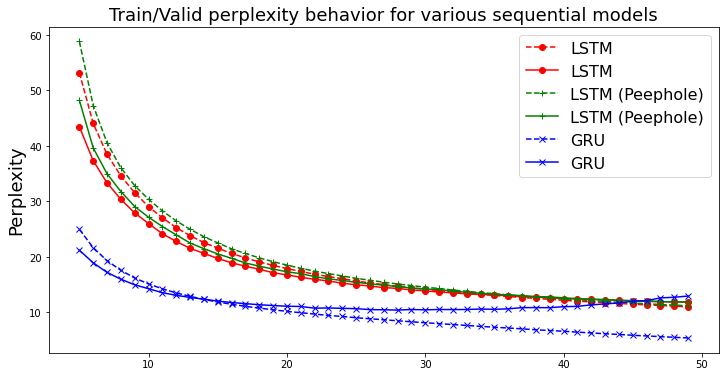

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plots without the Word2vec related results
plt.figure(figsize=(12, 6)) 
k = 5

for model_name, history, marker, color in zip(
    ['LSTM', 'LSTM (Peephole)', 'GRU'], 
    [lstm_history, lstm_peephole_history, gru_history],
    ['o', '+', 'x'],
    ['red', 'green', 'blue']
):
    
    train_perplexity = history.history["perplexity"][k:]
    val_perplexity = history.history["val_perplexity"][k:]
    
    # Plot the training perplexities
    plt.plot(np.arange(k,len(train_perplexity)+k), 
               train_perplexity, marker=marker, markersize=6, linestyle='--' , color=color,
               label = model_name)
    
    plt.plot(np.arange(k, len(val_perplexity)+k), 
           val_perplexity, marker=marker, markersize=6, color=color,
           label = model_name)

plt.legend(loc=1,fontsize=16)
plt.title('Train/Valid perplexity behavior for various sequential models',fontsize=18)
plt.ylabel('Perplexity',fontsize=18)


## LSTM with Beam-Search

Here we alter the previously defined prediction related TensorFlow operations to employ beam-search. Beam search is a way of predicting several time steps ahead. Concretely instead of predicting the best prediction we have at a given time step, we get predictions for several time steps and get the sequence of highest joint probability.

In [43]:
def beam_one_step(model, input_, states): 
    """ Perform the model update and output for one step"""
    out = model.predict([input_, *states])
    output, new_states = out[0], out[1:]
    return output, new_states


def beam_search(model, input_, states, beam_depth=5, beam_width=3):
    """ Defines an outer wrapper for the computational function of beam search """
    
    vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
    index_word = dict(zip(range(len(vocabulary)), vocabulary))

    def recursive_fn(input_, states, sequence, log_prob, i):
        """ This function performs actual recursive computation of the long string"""
        
        if i == beam_depth:
            """ Base case: Terminate the beam search """
            results.append((list(sequence), states, np.exp(log_prob)))            
            return sequence, log_prob, states
        else:
            """ Recursive case: Keep computing the output using the previous outputs"""
            output, new_states = beam_one_step(model, input_, states)
            
            # Get the top beam_widht candidates for the given depth
            top_probs, top_ids = tf.nn.top_k(output, k=beam_width)
            top_probs, top_ids = top_probs.numpy().ravel(), top_ids.numpy().ravel()
            
            # For each candidate compute the next prediction
            for p, wid in zip(top_probs, top_ids):                
                new_log_prob = log_prob + np.log(p)
                
                # we are going to penalize joint probability whenever the same symbol is repeating
                if len(sequence)>0 and wid == sequence[-1]:
                    new_log_prob = new_log_prob + np.log(1e-1)
                    
                sequence.append(wid)                
                _ = recursive_fn(np.array([[index_word[wid]]]), new_states, sequence, new_log_prob, i+1)                                         
                sequence.pop()
        
    
    results = []
    sequence = []
    log_prob = 0.0
    recursive_fn(input_, states, sequence, log_prob, 0)    

    results = sorted(results, key=lambda x: x[2], reverse=True)

    return results

In [48]:
text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))


seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print("Making {} predictions from input".format(len(seq)))


# Reset the state of the model initially
lm_model.reset_states()

# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

states = [state_c, state_h, state_c_1, state_h_1]

# Recursively update the model by assining new state to state
for c in seq:    
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Predict for 100 time steps
for i in range(50):    
    print('.', end='')
    
    # Get the results from beam search
    result = beam_search(infer_model, x, states, 5, 5)
    
    # Get one of the top 10 results based on their likelihood
    n_probs = np.array([p for _,_,p in result[:10]])
    p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())                    
    best_beam_ids, states, _ = result[p_j]
    x = np.array([[index_word[best_beam_ids[-1]]]])
            
    text.extend([index_word[w] for w in best_beam_ids])    

print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

Making 58 predictions from input
..................................................

Final text: 
When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren groundr, said the king's daughter went out of the king's son to the king's daughter, and then the king's daughter went into the world, and asked the hedgehog's daughter that the king was about to the forest, and there was on the window, and said, "if you will give her that you have been and said, i will give him the king's daughter, but when she went to the king's sister, and when she was still before the window, and said to himself, and when he said to her father, and that he had nothing and said to hi
